In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [10]:
image_folder="ParticipantScans\\GAN\\LeaveOut_002\\Results\\images\\Cropped"

In [11]:
from local_vars import root_folder

image_fullpath = os.path.join(root_folder, image_folder)

target_file_list = [f for f in os.listdir(image_fullpath) if f.endswith('-targets_cropped.png')]
output_file_list = [f for f in os.listdir(image_fullpath) if f.endswith('-outputs_cropped.png')]

num_target_images = len(target_file_list)
num_output_images = len(output_file_list)

print( "Found {} target image files".format(num_target_images))
print( "Found {} output image files".format(num_output_images))

Found 96 target image files
Found 96 output image files


In [8]:
from sklearn import metrics

def mutualinfo(a,b):
    #compute the normalized mutual information score for the two images
    #"amount of information" you can tell about one image from the other
    a = [item for sublist in a.tolist() for item in sublist]
    b = [item for sublist in b.tolist() for item in sublist]
    
    mi = metrics.normalized_mutual_info_score(a, b, average_method='arithmetic')
    return mi
    

In [5]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [6]:
from skimage import measure

def compare_images(imageA, imageB, display):
    # compute the mean squared error, structural similarity, and mutual info
    # for the images
    m = mse(imageA, imageB)
    s = measure.compare_ssim(imageA, imageB)
    mi = mutualinfo(imageA, imageB)
    
    if display:
        # setup the figure
        fig = plt.figure()
        plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

        # show first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(imageA, cmap = plt.cm.gray)
        plt.axis("off")

        # show the second image
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(imageB, cmap = plt.cm.gray)
        plt.axis("off")

        # show the images
        plt.show()
    
    return m, s, mi

In [15]:
print("Reading and comparing files...")

sum_mse = 0
sum_ssim = 0
sum_mi = 0

top5 = [(0, 0, ""), (0, 0, ""), (0, 0, ""), (0, 0, ""), (0, 0, "")]

for i in range(num_output_images):
    target_file_name = target_file_list[i]
    target_file_fullname = os.path.join(image_fullpath, target_file_name)
    output_file_name = output_file_list[i]
    output_file_fullname = os.path.join(image_fullpath, output_file_name)
    
    target_image = cv2.imread(target_file_fullname, 0)
    output_image = cv2.imread(output_file_fullname, 0)
    
    #target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
    #output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
    
    m, s, mi = compare_images(target_image, output_image, False)
    
    if i < 5:
        top5[i] = (s, i, target_file_name)
    else:
        top5.sort(key=lambda tup: tup[0])
        if s > top5[4][0]:
            top5[4] = (s, i, target_file_name)
        elif s > top5[3][0]:
            top5[3] = (s, i, target_file_name)
        elif s > top5[2][0]:
            top5[2] = (s, i, target_file_name)
        elif s > top5[1][0]:
            top5[1] = (s, i, target_file_name)
        elif s > top5[0][0]:
            top5[0] = (s, i, target_file_name)
    
    #print(top5)

    
    sum_mse += m
    sum_ssim += s
    sum_mi += mi
    
average_mse = sum_mse / num_target_images
average_ssim = sum_ssim / num_target_images
average_mi = sum_mi / num_target_images
print("Average mse: {} \nAverage ssim: {} \nAverage mi: {}".format(average_mse,average_ssim, average_mi))
print(top5)

Reading and comparing files...
Average mse: 262.86391352681284 
Average ssim: 0.6551927597382085 
Average mi: 0.18872215683380159
[(0.6867955657251734, 84, 'right_kidney002_0085-targets_cropped.png'), (0.6889351623360347, 83, 'right_kidney002_0084-targets_cropped.png'), (0.7062320927398569, 25, 'right_kidney002_0026-targets_cropped.png'), (0.708674409792695, 19, 'right_kidney002_0020-targets_cropped.png'), (0.717419836575536, 24, 'right_kidney002_0025-targets_cropped.png')]


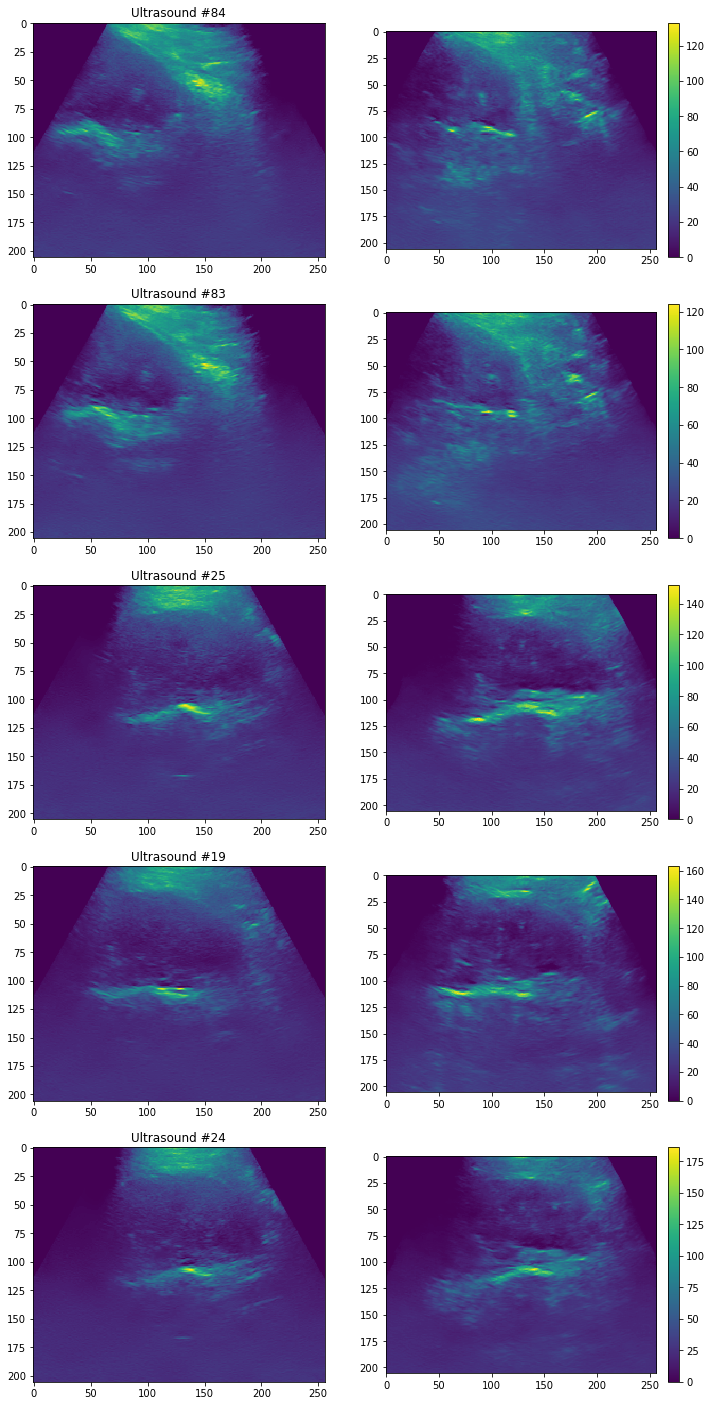

In [16]:
fig = plt.figure(figsize=(18, 5*5))
for i in range(5):
    
    index = top5[i][1]
        
    target_file_name = top5[i][2]
    target_file_fullname = os.path.join(image_fullpath, target_file_name)
    output_file_name = output_file_list[index]
    output_file_fullname = os.path.join(image_fullpath, output_file_name)
    
    target_image = cv2.imread(target_file_fullname, 0)
    output_image = cv2.imread(output_file_fullname, 0)
    
    #print(target)
    
    
    a1 = fig.add_subplot(5,3,i*3+2)
    img1 = a1.imshow(target_image.astype(np.float32))
    a1.set_title("Ultrasound #{}".format(index))

    a2 = fig.add_subplot(5,3,i*3+3)
    img2 = a2.imshow(output_image.astype(np.float32))
    c2 = fig.colorbar(img2, fraction=0.046, pad=0.04)